<a href="https://colab.research.google.com/github/sudoyolo/ProfanityMasker/blob/main/Fine_Tune_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug  7 03:59:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
!git clone --depth 1 -b v2.13.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2224, done.
remote: Counting objects: 100% (2224/2224), done.
remote: Compressing objects: 100% (1593/1593), done.
remote: Total 2224 (delta 713), reused 1019 (delta 595), pack-reused 0
Receiving objects: 100% (2224/2224), 18.47 MiB | 7.79 MiB/s, done.
Resolving deltas: 100% (713/713), done.
Note: switching to '6db73770b90aca5e8110478aed79b0fc5d06355c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [4]:
# Install requirements to use tensorflow/models repository
# Restart the runtime afterwards
!pip install tf-models-official

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.tools import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.13.0
Eager mode:  True
Hub version:  0.14.0
GPU is available


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                   compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [4]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

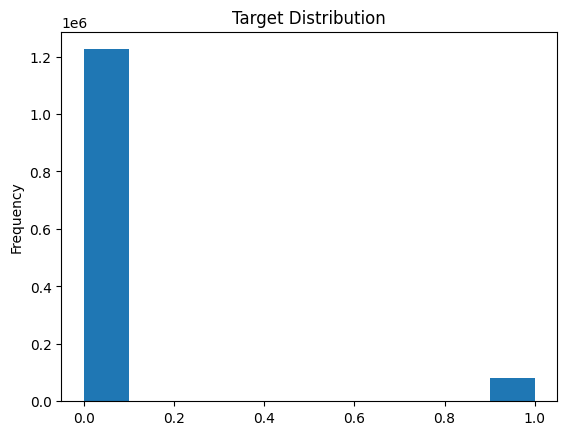

In [5]:
df.target.plot(kind='hist', title='Target Distribution')

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [6]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [7]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [8]:
# Get BERT layer and tokenizer: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

label_list = [0, 1]
max_seq_length = 128
train_batch_size =32
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [10]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

In [11]:
# Function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a=text.numpy(),
                                             text_b=None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return(feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)



I used [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. `Dataset.map` runs in graph mode.

- Graph tensors do not have a value.
- In graph mode, you can only use TensorFlow Ops and functions.

Thus, `.map` function cannot be used directly. I wrapped it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function).

The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [12]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_words_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return (x, label_id)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [13]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [14]:
# train data spec
train_data.element_spec

({'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [15]:
# valid data spec
valid_data.element_spec

({'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

In [18]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
          'input_words_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [19]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

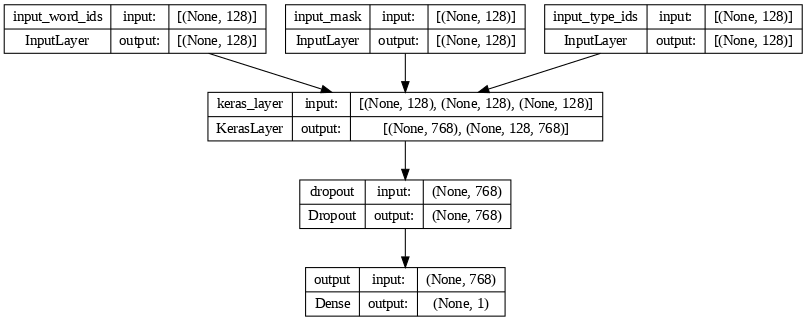

In [20]:
tf.keras.utils.plot_model(model=model,show_shapes=True, dpi=76)

In [21]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - 296s 800ms/step - loss: 0.1759 - binary_accuracy: 0.9350 - val_loss: 0.1306 - val_binary_accuracy: 0.9552
Epoch 2/4
306/306 [==============================] - 248s 807ms/step - loss: 0.1081 - binary_accuracy: 0.9582 - val_loss: 0.1158 - val_binary_accuracy: 0.9594
Epoch 3/4
306/306 [==============================] - 248s 807ms/step - loss: 0.0615 - binary_accuracy: 0.9803 - val_loss: 0.1533 - val_binary_accuracy: 0.9521
Epoch 4/4
306/306 [==============================] - 245s 798ms/step - loss: 0.0368 - binary_accuracy: 0.9897 - val_loss: 0.2125 - val_binary_accuracy: 0.9406


Most probably overfitted model from 2nd epoch onwards as validation loss starts to increase.

Can run fewer epochs, add more regularization layers, experiment with batch size, etc. to fix the problem of overfitting.

## Task 11: Evaluate the BERT Text Classification Model

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

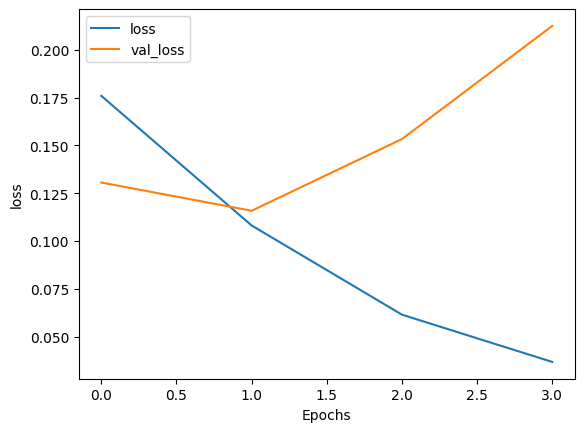

In [24]:
plot_graphs(history, 'loss')

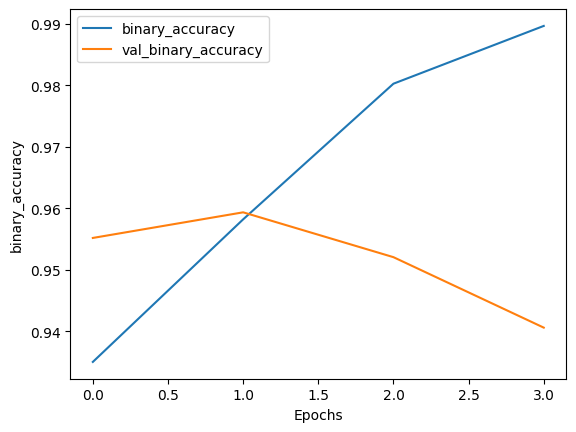

In [25]:
plot_graphs(history, 'binary_accuracy')

In [29]:
sample_example = ['Can I have your email?', 'You should die.']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5
['Insincere' if pred >=threshold else 'Sincere' for pred in preds]

2/2 [==============================] - 0s 20ms/step


['Sincere', 'Insincere']